# StreamerReader Advanced usages

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import IPython
import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

base_url = "https://download.pytorch.org/torchaudio/tutorial-assets"
AUDIO_URL = f"{base_url}/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
VIDEO_URL = f"{base_url}/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

2.1.0
2.1.0


## Audio / Video device input

The following example illustrates how one can do this on MacBook Pro.

First, we need to check the available devices.

```bash
$ ffmpeg -f avfoundation -list_devices true -i ""
[AVFoundation indev @ 0x143f04e50] AVFoundation video devices:
[AVFoundation indev @ 0x143f04e50] [0] FaceTime HD Camera
[AVFoundation indev @ 0x143f04e50] [1] Capture screen 0
[AVFoundation indev @ 0x143f04e50] AVFoundation audio devices:
[AVFoundation indev @ 0x143f04e50] [0] MacBook Pro Microphone
```

Example:

```python
streamer = StreamReader(
    src="0:0", 
    format="avfoundation", 
    option={"framerate": "30", "pixel_format": "bgr0"},)

for i in range(streamer.num_src_streams):
    print(streamer.get_src_stream_info(i))
```


## Synthentic source streams

### Audio example

To use this, we set `format=lavfi` and provide a filter description to `src`.

The detail of filter description can be found at https://ffmpeg.org/ffmpeg-filters.html

In [5]:
StreamReader(src="sine=sample_rate=8000:frequency=360", format="lavfi")

In [6]:
# 5 Hz binaural beats on a 360 Hz carrier
StreamReader(
    src=(
        'aevalsrc='
        'sample_rate=8000:'
        'exprs=0.1*sin(2*PI*(360-5/2)*t)|0.1*sin(2*PI*(360+5/2)*t)'
    ),
    format='lavfi',
)

### Video example

In [7]:
StreamReader(src=f"cellauto", format="lavfi")

## Custom filters

### Audio example

In [8]:
# fmt: off
descs = [
    # No filtering
    "anull",
    # Apply a highpass filter then a lowpass filter
    "highpass=f=200,lowpass=f=1000",
    # Manipulate spectrogram
    (
        "afftfilt="
        "real='hypot(re,im)*sin(0)':"
        "imag='hypot(re,im)*cos(0)':"
        "win_size=512:"
        "overlap=0.75"
    ),
    # Manipulate spectrogram
    (
        "afftfilt="
        "real='hypot(re,im)*cos((random(0)*2-1)*2*3.14)':"
        "imag='hypot(re,im)*sin((random(1)*2-1)*2*3.14)':"
        "win_size=128:"
        "overlap=0.8"
    ),
]
# fmt: on

#### Original audio

In [9]:
sample_rate = 8000

streamer = StreamReader(AUDIO_URL)
for desc in descs:
    streamer.add_audio_stream(
        frames_per_chunk=40000,
        filter_desc=f"aresample={sample_rate},{desc},aformat=sample_fmts=fltp",
    )

chunks = next(streamer.stream())


def _display(i):
    print("filter_desc:", streamer.get_out_stream_info(i).filter_description)
    fig, axs = plt.subplots(2, 1)
    waveform = chunks[i][:, 0]
    axs[0].plot(waveform)
    axs[0].grid(True)
    axs[0].set_ylim([-1, 1])
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].specgram(waveform, Fs=sample_rate)
    fig.tight_layout()
    return IPython.display.Audio(chunks[i].T, rate=sample_rate)

filter_desc: aresample=8000,anull,aformat=sample_fmts=fltp


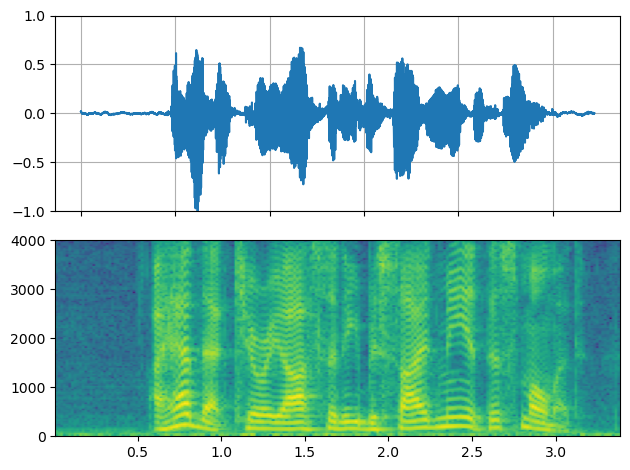

In [10]:
_display(0)

#### Highpass / lowpass filter

filter_desc: aresample=8000,highpass=f=200,lowpass=f=1000,aformat=sample_fmts=fltp


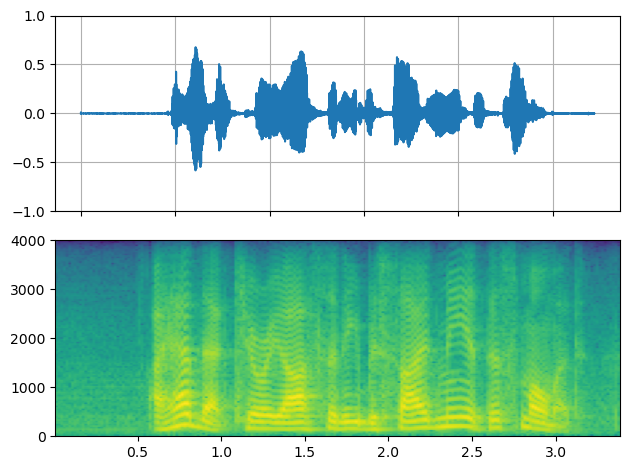

In [11]:
_display(1)

#### FFT filter - Robot 🤖

filter_desc: aresample=8000,afftfilt=real='hypot(re,im)*sin(0)':imag='hypot(re,im)*cos(0)':win_size=512:overlap=0.75,aformat=sample_fmts=fltp


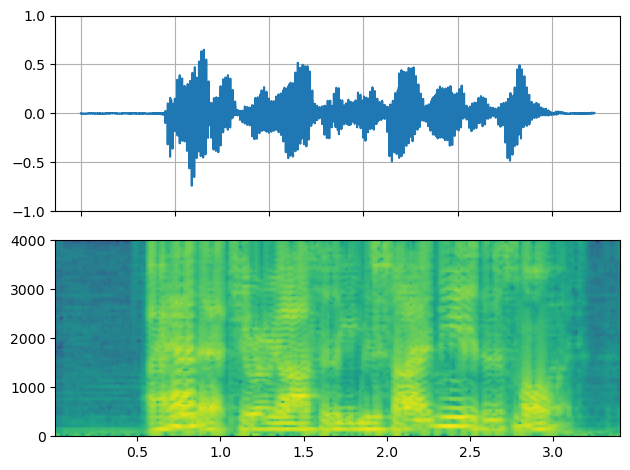

In [12]:
_display(2)

#### FFT filter - Whisper

filter_desc: aresample=8000,afftfilt=real='hypot(re,im)*cos((random(0)*2-1)*2*3.14)':imag='hypot(re,im)*sin((random(1)*2-1)*2*3.14)':win_size=128:overlap=0.8,aformat=sample_fmts=fltp


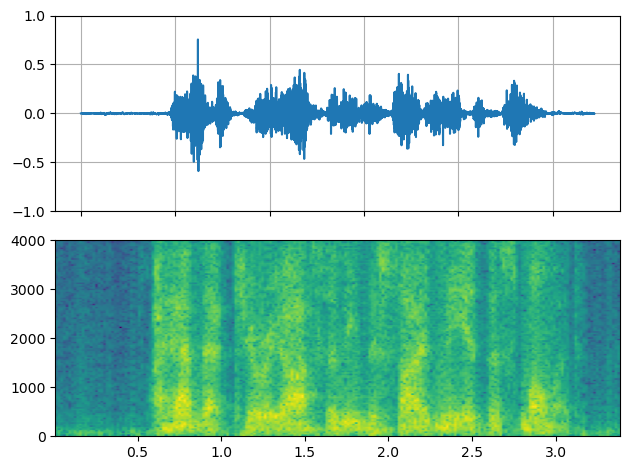

In [13]:
_display(3)

### Video example

In [14]:
# fmt: off
descs = [
    # No effect
    "null",
    # Split the input stream and apply horizontal flip to the right half.
    (
        "split [main][tmp];"
        "[tmp] crop=iw/2:ih:0:0, hflip [flip];"
        "[main][flip] overlay=W/2:0"
    ),
    # Edge detection
    "edgedetect=mode=canny",
    # Rotate image by randomly and fill the background with brown
    "rotate=angle=-random(1)*PI:fillcolor=brown",
    # Manipulate pixel values based on the coordinate
    "geq=r='X/W*r(X,Y)':g='(1-X/W)*g(X,Y)':b='(H-Y)/H*b(X,Y)'"
]
# fmt: on

In [15]:
streamer = StreamReader(VIDEO_URL)
for desc in descs:
    streamer.add_video_stream(
        frames_per_chunk=30,
        filter_desc=f"fps=10,{desc},format=pix_fmts=rgb24",
    )

streamer.seek(12)

chunks = next(streamer.stream())


def _display(i):
    print("filter_desc:", streamer.get_out_stream_info(i).filter_description)
    _, axs = plt.subplots(1, 3, figsize=(8, 1.9))
    chunk = chunks[i]
    for j in range(3):
        axs[j].imshow(chunk[10 * j + 1].permute(1, 2, 0))
        axs[j].set_axis_off()
    plt.tight_layout()

#### Original video

filter_desc: fps=10,null,format=pix_fmts=rgb24


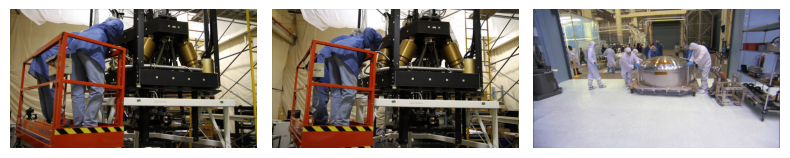

In [16]:
_display(0)

#### Mirror

filter_desc: fps=10,split [main][tmp];[tmp] crop=iw/2:ih:0:0, hflip [flip];[main][flip] overlay=W/2:0,format=pix_fmts=rgb24


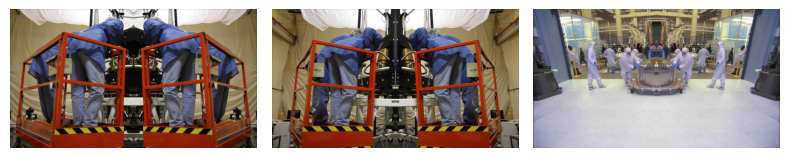

In [17]:
_display(1)

#### Edge detection

filter_desc: fps=10,edgedetect=mode=canny,format=pix_fmts=rgb24


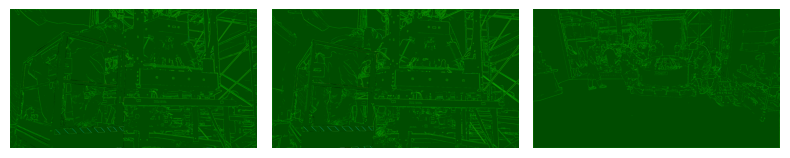

In [18]:
_display(2)

#### Random rotation

filter_desc: fps=10,rotate=angle=-random(1)*PI:fillcolor=brown,format=pix_fmts=rgb24


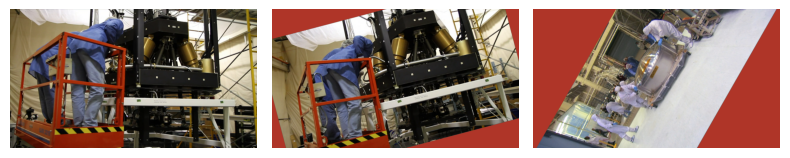

In [19]:
_display(3)

#### Pixel manipulation

filter_desc: fps=10,geq=r='X/W*r(X,Y)':g='(1-X/W)*g(X,Y)':b='(H-Y)/H*b(X,Y)',format=pix_fmts=rgb24


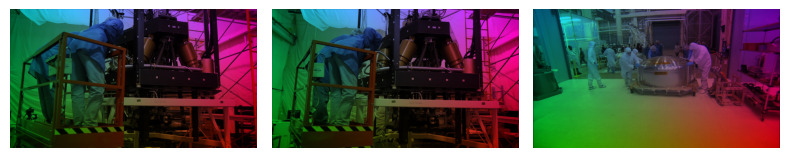

In [20]:
_display(4)